# LSTM Siamese Model Training Notebook

This notebook focuses on **training** the LSTM Siamese model with detailed steps. The trained model will then be used for inference in the Kubeflow pipeline.

## Training Workflow:
1. **Data Preparation** - Extract and prepare training data from Hive
2. **Exploratory Data Analysis** - Understand data distribution and quality
3. **Text Preprocessing** - Clean and tokenize text data
4. **Model Architecture Design** - Configure LSTM Siamese architecture
5. **Training Process** - Train model with monitoring and validation
6. **Model Evaluation** - Assess performance and tune hyperparameters
7. **Model Export** - Save trained model for production inference
8. **Training Documentation** - Generate training report and metadata

## 1. Environment Setup

In [1]:
# Import required libraries
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import sys
from typing import List, Dict, Any, Tuple
import logging
import pickle

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Bidirectional, Dropout, Lambda
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

warnings.filterwarnings('ignore')
sys.path.append('.')

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Check GPU availability
print("🔍 System Information:")
print(f"  TensorFlow version: {tf.__version__}")
print(f"  GPU available: {tf.config.list_physical_devices('GPU')}")
print(f"  CPU cores: {os.cpu_count()}")

print("✅ Environment setup completed!")

2025-07-23 18:23:37.127508: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-23 18:23:37.177746: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


🔍 System Information:
  TensorFlow version: 2.13.0
  GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
  CPU cores: 8
✅ Environment setup completed!


2025-07-23 18:23:39.364845: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-23 18:23:39.371210: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-23 18:23:39.371354: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## 2. Training Configuration

In [14]:
# Hive Configuration
HIVE_CONFIG = {
    'host': '172.17.235.21',
    'port': 10000,
    'database': 'preprocessed_analytics',
    'username': 'lhimer'
}

# Data Configuration
DATA_CONFIG = {
    'input_table': 'preprocessed_analytics.model_reference',
    'temp_dir': './training_data',
    'raw_data_path': './training_data/raw_data.csv',
    'processed_data_path': './training_data/processed_data.csv',
    'training_data_path': './training_data/training_pairs.csv',
    'validation_data_path': './training_data/validation_pairs.csv',
    'test_data_path': './training_data/test_pairs.csv',
    'sample_size': 10000,  # Larger sample for training
    'matching_mode': 'cross_product',  # Generate training pairs
    'balance_ratio': 0.5  # 50% similar, 50% dissimilar
}

# Model Architecture Configuration
MODEL_CONFIG = {
    'embedding_dim': 300,
    'max_sequence_length': 100,
    'number_lstm': 128,  # Larger for better capacity
    'rate_drop_lstm': 0.3,
    'number_dense_units': 64,
    'activation_function': 'relu',
    'rate_drop_dense': 0.3,
    'optimizer': 'adam',
    'learning_rate': 0.001
}

# Training Configuration
TRAINING_CONFIG = {
    'validation_split': 0.2,
    'test_split': 0.1,
    'epochs': 50,  # More epochs for thorough training
    'batch_size': 128,
    'early_stopping_patience': 10,
    'reduce_lr_patience': 5,
    'reduce_lr_factor': 0.5,
    'min_learning_rate': 1e-7
}

# Output Configuration
OUTPUT_CONFIG = {
    'model_dir': './trained_models',
    'model_name': 'lstm_siamese_model',
    'timestamp': datetime.now().strftime('%Y%m%d_%H%M%S'),
    'save_best_only': True,
    'save_weights_only': False
}

# Create directories
for dir_path in [DATA_CONFIG['temp_dir'], OUTPUT_CONFIG['model_dir']]:
    os.makedirs(dir_path, exist_ok=True)

print("📋 Training Configuration:")
print(f"  Model: LSTM({MODEL_CONFIG['number_lstm']}) + Dense({MODEL_CONFIG['number_dense_units']})")
print(f"  Training samples: {DATA_CONFIG['sample_size']}")
print(f"  Epochs: {TRAINING_CONFIG['epochs']}")
print(f"  Batch size: {TRAINING_CONFIG['batch_size']}")
print(f"  Sequence length: {MODEL_CONFIG['max_sequence_length']}")
print(f"  Output directory: {OUTPUT_CONFIG['model_dir']}")

print("✅ Configuration loaded!")

📋 Training Configuration:
  Model: LSTM(128) + Dense(64)
  Training samples: 10000
  Epochs: 50
  Batch size: 128
  Sequence length: 100
  Output directory: ./trained_models
✅ Configuration loaded!


## 3. Data Extraction and Preparation

In [ ]:
import os
import json
import argparse
from typing import Dict, List, Optional, Tuple
from datetime import datetime
import pandas as pd
import numpy as np
from pyhive import hive
from thrift.transport import TSocket
from thrift.transport import TTransport
from thrift.protocol import TBinaryProtocol
import random
import string


class HiveSiameseDataExtractor:
    """
    Class to extract data from Hive tables and prepare for LSTM Siamese text similarity pipeline.
    """
    
    def __init__(self, host: str, port: int = 10000, username: str = None, database: str = "default"):
        """Initialize Hive connection parameters."""
        self.host = host
        self.port = port
        self.username = username
        self.database = database
        self.connection = None
    
    def connect(self):
        """Establish connection to Hive."""
        try:
            self.connection = hive.Connection(
                host=self.host,
                port=self.port,
                database=self.database,
                username=self.username
            )
            print(f"✅ Connected to Hive: {self.host}:{self.port}/{self.database}")
            return True
        except Exception as e:
            print(f"❌ Failed to connect to Hive: {e}")
            return False
    
    def disconnect(self):
        """Close Hive connection."""
        if self.connection:
            self.connection.close()
            print("🔌 Hive connection closed")
    
    def execute_query(self, query: str) -> pd.DataFrame:
        """Execute SQL query and return results as DataFrame."""
        if not self.connection:
            raise RuntimeError("Not connected to Hive")
        
        try:
            df = pd.read_sql(query, self.connection)
            print(f"📊 Query executed successfully, returned {len(df)} rows")
            return df
        except Exception as e:
            print(f"❌ Query failed: {e}")
            raise
    
    def add_random_char(self, text):
        """Add a random letter to the text at a random position"""
        if pd.isna(text) or text == '':
            return text
        text = str(text)
        pos = random.randint(0, len(text))
        char = random.choice(string.ascii_uppercase)
        return text[:pos] + char + text[pos:]
    
    def remove_random_chars(self, text, num_chars=1):
        """Remove 1-2 random characters from the text"""
        if pd.isna(text) or text == '' or len(str(text)) <= num_chars:
            return text
        text = str(text)
        for _ in range(min(num_chars, len(text))):
            if len(text) > 1:
                pos = random.randint(0, len(text) - 1)
                text = text[:pos] + text[pos + 1:]
        return text
    
    def change_random_chars(self, text, num_chars=1):
        """Change 1-2 random characters in the text"""
        if pd.isna(text) or text == '':
            return text
        text = str(text)
        text_list = list(text)
        positions = random.sample(range(len(text_list)), min(num_chars, len(text_list)))
        
        for pos in positions:
            if text_list[pos].isalpha():
                text_list[pos] = random.choice(string.ascii_uppercase)
            elif text_list[pos].isdigit():
                text_list[pos] = random.choice(string.digits)
        
        return ''.join(text_list)
    
    def augment_field(self, text):
        """Apply one of the augmentation operations to a field"""
        operations = [
            lambda x: self.add_random_char(x),
            lambda x: self.remove_random_chars(x, 1),
            lambda x: self.remove_random_chars(x, 2),
            lambda x: self.change_random_chars(x, 1),
            lambda x: self.change_random_chars(x, 2)
        ]
        
        operation = random.choice(operations)
        return operation(text)
    
    def augment_row(self, row):
        """Augment a single row by modifying 1-2 fields"""
        new_row = row.copy()
        
        # Get field names excluding empty ones
        non_empty_fields = [col for col in row.index 
                          if not pd.isna(row[col]) and str(row[col]).strip() != '']
        
        if len(non_empty_fields) == 0:
            return new_row
        
        # Randomly choose 1 or 2 fields to modify
        num_fields_to_modify = random.choice([1, 2])
        num_fields_to_modify = min(num_fields_to_modify, len(non_empty_fields))
        
        fields_to_modify = random.sample(non_empty_fields, num_fields_to_modify)
        
        for field in fields_to_modify:
            new_row[field] = self.augment_field(row[field])
        
        return new_row
    
    def row_to_natural_sentence(self, row, df_columns):
        """Convert a row to natural language sentence format"""
        sentence_parts = []
        
        for col in df_columns:
            if pd.notna(row[col]) and str(row[col]).strip():
                # Clean column name - remove table prefixes and make readable
                clean_col = col.split('.', 1)[1] if '.' in col else col
                clean_col = clean_col.replace('_', ' ')
                
                value = str(row[col]).strip()
                sentence_parts.append(f"my {clean_col} is {value}")
        
        return " and ".join(sentence_parts)
    
    def detect_table_structure(self, df: pd.DataFrame) -> Dict[str, any]:
        """
        Detect if table has _left/_right columns (production) or single columns (testing).
        
        Args:
            df: DataFrame to analyze
            
        Returns:
            Dictionary with structure information
        """
        columns = list(df.columns)
        
        # Remove table prefixes first to analyze column structure
        clean_columns = []
        for col in columns:
            if '.' in col:
                clean_col = col.split('.', 1)[1]
            else:
                clean_col = col
            clean_columns.append(clean_col)
        
        # Check for _left and _right patterns
        left_columns = [col for col in clean_columns if col.endswith('_left')]
        right_columns = [col for col in clean_columns if col.endswith('_right')]
        
        # Extract base field names
        left_fields = {col[:-5] for col in left_columns}  # Remove '_left'
        right_fields = {col[:-6] for col in right_columns}  # Remove '_right'
        
        # Check if we have matching left/right pairs
        matching_fields = left_fields.intersection(right_fields)
        
        if matching_fields:
            structure_type = "production"
            message = f"🏭 Production table detected with {len(matching_fields)} matching field pairs"
        else:
            structure_type = "testing"
            message = f"🧪 Testing table detected with {len(clean_columns)} fields for training data generation"
        
        return {
            'type': structure_type,
            'columns': columns,
            'clean_columns': clean_columns,
            'left_columns': left_columns,
            'right_columns': right_columns,
            'matching_fields': list(matching_fields),
            'message': message
        }
    
    def convert_production_format(self, df: pd.DataFrame, structure: Dict) -> pd.DataFrame:
        """Convert production table with _left/_right columns to LSTM Siamese format."""
        records = []
        
        for idx, row in df.iterrows():
            # Build left and right sentences
            left_parts = []
            right_parts = []
            
            for field in structure['matching_fields']:
                # Find the actual column names (with potential table prefixes)
                left_col = None
                right_col = None
                
                for col in df.columns:
                    clean_col = col.split('.', 1)[1] if '.' in col else col
                    if clean_col == f"{field}_left":
                        left_col = col
                    elif clean_col == f"{field}_right":
                        right_col = col
                
                # Process left column
                if left_col and pd.notna(row[left_col]) and str(row[left_col]).strip():
                    value = str(row[left_col]).strip()
                    left_parts.append(f"my {field} is {value}")
                
                # Process right column
                if right_col and pd.notna(row[right_col]) and str(row[right_col]).strip():
                    value = str(row[right_col]).strip()
                    right_parts.append(f"my {field} is {value}")
            
            left_text = " and ".join(left_parts)
            right_text = " and ".join(right_parts)
            
            # For production, determine similarity
            # This could be based on exact match, fuzzy match, or existing label column
            is_similar = 1 if left_text.lower().strip() == right_text.lower().strip() else 0
            
            # Check if there's an existing similarity/match column
            similarity_cols = [col for col in df.columns if any(sim_term in col.lower() 
                             for sim_term in ['similar', 'match', 'label', 'ground_truth'])]
            if similarity_cols:
                # Use existing ground truth if available
                is_similar = int(row[similarity_cols[0]]) if pd.notna(row[similarity_cols[0]]) else is_similar
            
            record = {
                'sentences1': left_text,
                'sentences2': right_text,
                'is_similar': is_similar
            }
            records.append(record)
        
        result_df = pd.DataFrame(records)
        print(f"✅ Successfully converted {len(records)} production records with left/right pairs")
        return result_df
    
    def convert_testing_format(self, df: pd.DataFrame, structure: Dict) -> pd.DataFrame:
        """Convert testing table for self-matching to LSTM Siamese format."""
        records = []
        
        for idx, row in df.iterrows():
            # Convert row to natural language sentence
            record_text = self.row_to_natural_sentence(row, df.columns)
            
            # Create record for self-matching (similar to itself)
            record = {
                'sentences1': record_text,
                'sentences2': record_text,  # Same record for self-matching
                'is_similar': 1  # Same record is always similar
            }
            records.append(record)
        
        result_df = pd.DataFrame(records)
        print(f"✅ Successfully converted {len(records)} testing records for self-matching")
        return result_df
    
    def create_text_pairs(self, df: pd.DataFrame, mode: str = 'auto') -> pd.DataFrame:
        """
        Create text pairs for LSTM Siamese training from different sources.
        
        Args:
            df: Input DataFrame
            mode: 'auto', 'production', 'testing', or 'cross_product'
            
        Returns:
            DataFrame with sentences1, sentences2, is_similar columns
        """
        if mode == 'cross_product':
            return self.create_cross_product_pairs(df)
        
        # Detect table structure
        structure = self.detect_table_structure(df)
        print(structure['message'])
        
        if structure['type'] == 'production' and mode != 'testing':
            return self.convert_production_format(df, structure)
        else:
            return self.convert_testing_format(df, structure)
    
    def create_cross_product_pairs(self, df: pd.DataFrame, max_pairs: int = 10000, augmentations_per_row: int = 3) -> pd.DataFrame:
        """
        Create training pairs using augmentation strategy:
        1. For each original row, create augmented versions
        2. Pair original with augmented (similar pairs)
        3. Pair different rows (dissimilar pairs)
        4. Balance the dataset
        
        Args:
            df: Input DataFrame
            max_pairs: Maximum number of pairs to generate
            augmentations_per_row: Number of augmented versions per row
            
        Returns:
            DataFrame with sentence pairs and similarity labels
        """
        print(f"🔄 Creating training pairs with augmentation strategy...")
        print(f"  Original rows: {len(df)}")
        print(f"  Augmentations per row: {augmentations_per_row}")
        
        # Convert original rows to sentences
        original_sentences = []
        for idx, row in df.iterrows():
            sentence = self.row_to_natural_sentence(row, df.columns)
            original_sentences.append(sentence)
        
        # Generate augmented sentences
        augmented_data = []
        for idx, row in df.iterrows():
            original_sentence = self.row_to_natural_sentence(row, df.columns)
            
            # Create augmented versions
            for aug_num in range(augmentations_per_row):
                augmented_row = self.augment_row(row)
                augmented_sentence = self.row_to_natural_sentence(augmented_row, df.columns)
                augmented_data.append({
                    'original_idx': idx,
                    'original_sentence': original_sentence,
                    'augmented_sentence': augmented_sentence
                })
        
        print(f"  Generated {len(augmented_data)} augmented sentences")
        
        # Create pairs
        records = []
        
        # 1. Similar pairs: original vs augmented
        similar_pairs = 0
        for aug_data in augmented_data:
            if len(records) >= max_pairs // 2:  # Reserve half for similar pairs
                break
            
            record = {
                'sentences1': aug_data['original_sentence'],
                'sentences2': aug_data['augmented_sentence'],
                'is_similar': 1
            }
            records.append(record)
            similar_pairs += 1
        
        print(f"  Created {similar_pairs} similar pairs (original vs augmented)")
        
        # 2. Dissimilar pairs: different original sentences
        dissimilar_pairs = 0
        target_dissimilar = min(similar_pairs, max_pairs - similar_pairs)  # Balance with similar pairs
        
        attempts = 0
        max_attempts = target_dissimilar * 10  # Avoid infinite loop
        
        while dissimilar_pairs < target_dissimilar and attempts < max_attempts:
            # Pick two different random indices
            idx1 = random.randint(0, len(original_sentences) - 1)
            idx2 = random.randint(0, len(original_sentences) - 1)
            
            if idx1 != idx2:  # Ensure different sentences
                record = {
                    'sentences1': original_sentences[idx1],
                    'sentences2': original_sentences[idx2],
                    'is_similar': 0
                }
                records.append(record)
                dissimilar_pairs += 1
            
            attempts += 1
        
        print(f"  Created {dissimilar_pairs} dissimilar pairs (different originals)")
        
        # Create final DataFrame
        result_df = pd.DataFrame(records)
        
        # Shuffle the pairs
        result_df = result_df.sample(frac=1, random_state=42).reset_index(drop=True)
        
        similar_count = result_df['is_similar'].sum()
        total_count = len(result_df)
        
        print(f"✅ Generated {total_count} pairs:")
        print(f"  Similar: {similar_count} ({similar_count/total_count:.1%})")
        print(f"  Dissimilar: {total_count - similar_count} ({(total_count - similar_count)/total_count:.1%})")
        
        return result_df
    
    def extract_and_convert(self, 
                          table_name: str, 
                          output_path: str,
                          sample_limit: Optional[int] = None,
                          matching_mode: str = 'auto',
                          balance_classes: bool = True,
                          max_pairs: int = 10000,
                          augmentations_per_row: int = 3) -> str:
        """
        Extract data from Hive table and convert to LSTM Siamese format.
        
        Args:
            table_name: Hive table name
            output_path: Path to save the converted data
            sample_limit: Limit number of records (None for all)
            matching_mode: 'auto', 'production', 'testing', or 'cross_product'
            balance_classes: Whether to balance similar/dissimilar pairs
            max_pairs: Maximum pairs to generate
            augmentations_per_row: Number of augmentations per row
            
        Returns:
            Path to the saved file
        """
        print(f"🔄 Extracting data from table: {table_name}")
        
        # Build query
        if sample_limit:
            query = f"SELECT * FROM {table_name} LIMIT {sample_limit}"
        else:
            query = f"SELECT * FROM {table_name}"
        
        # Execute query
        df = self.execute_query(query)
        print(f"📊 Extracted {len(df)} records")
        
        # Convert to Siamese format
        print(f"🔄 Converting to LSTM Siamese format (mode: {matching_mode})")
        if matching_mode == 'cross_product':
            siamese_df = self.create_cross_product_pairs(df, max_pairs, augmentations_per_row)
        else:
            siamese_df = self.create_text_pairs(df, mode=matching_mode)
        
        # Balance classes if requested and not already balanced
        if balance_classes and matching_mode not in ['cross_product']:
            siamese_df = self.balance_dataset(siamese_df)
        
        # Create output directory if needed
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        
        # Save to CSV
        siamese_df.to_csv(output_path, index=False)
        print(f"💾 Saved {len(siamese_df)} pairs to: {output_path}")
        
        # Show statistics
        similar_count = siamese_df['is_similar'].sum()
        total_count = len(siamese_df)
        print(f"📊 Dataset statistics:")
        print(f"  Total pairs: {total_count}")
        print(f"  Similar pairs: {similar_count} ({similar_count/total_count:.1%})")
        print(f"  Dissimilar pairs: {total_count - similar_count} ({(total_count - similar_count)/total_count:.1%})")
        
        return output_path
    
    def balance_dataset(self, df: pd.DataFrame, ratio: float = 0.5) -> pd.DataFrame:
        """
        Balance the dataset to have a specified ratio of similar/dissimilar pairs.
        
        Args:
            df: Input DataFrame with is_similar column
            ratio: Target ratio of similar pairs (0.5 = balanced)
            
        Returns:
            Balanced DataFrame
        """
        similar_df = df[df['is_similar'] == 1]
        dissimilar_df = df[df['is_similar'] == 0]
        
        similar_count = len(similar_df)
        dissimilar_count = len(dissimilar_df)
        
        print(f"🎯 Balancing dataset (current: {similar_count} similar, {dissimilar_count} dissimilar)")
        
        if ratio == 0.5:
            # Equal balance
            target_count = min(similar_count, dissimilar_count)
            if target_count == 0:
                print("⚠️  Cannot balance - one class has no samples")
                return df
                
            balanced_similar = similar_df.sample(n=target_count, random_state=42)
            balanced_dissimilar = dissimilar_df.sample(n=target_count, random_state=42)
        else:
            # Custom ratio
            total_target = min(len(df), max(similar_count, dissimilar_count) * 2)
            similar_target = int(total_target * ratio)
            dissimilar_target = total_target - similar_target
            
            balanced_similar = similar_df.sample(n=min(similar_target, similar_count), 
                                               random_state=42, replace=similar_target > similar_count)
            balanced_dissimilar = dissimilar_df.sample(n=min(dissimilar_target, dissimilar_count), 
                                                     random_state=42, replace=dissimilar_target > dissimilar_count)
        
        balanced_df = pd.concat([balanced_similar, balanced_dissimilar], ignore_index=True)
        balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle
        
        print(f"✅ Balanced dataset: {len(balanced_df)} pairs "
              f"({balanced_df['is_similar'].sum()} similar, {len(balanced_df) - balanced_df['is_similar'].sum()} dissimilar)")
        
        return balanced_df

In [ ]:
# Extract training data from Hive
print("🔄 Extracting training data from Hive...")

try:    
    extractor = HiveSiameseDataExtractor(
        host=HIVE_CONFIG['host'],
        port=HIVE_CONFIG['port'],
        username=HIVE_CONFIG['username'],
        database=HIVE_CONFIG['database']
    )
    
    if extractor.connect():
        print("✅ Connected to Hive successfully")
        
        # Extract data with cross-product mode for training
        training_data_path = extractor.extract_and_convert(
            table_name=DATA_CONFIG['input_table'],
            output_path=DATA_CONFIG['training_data_path'],
            sample_limit=DATA_CONFIG['sample_size'],
            matching_mode=DATA_CONFIG['matching_mode'],
            balance_classes=True,
            max_pairs=10000,  # Generate up to 10k pairs
            augmentations_per_row=3  # 3 augmented versions per row
        )
        
        print(f"✅ Training data extracted to: {training_data_path}")
        extractor.disconnect()
        
        # Load the generated training data
        training_df = pd.read_csv(training_data_path)
        
    else:
        raise Exception("Failed to connect to Hive")
        
except Exception as e:
    print(f"❌ Error extracting from Hive: {e}")
    print("💡 Creating synthetic training data for demonstration...")
    
    # Create synthetic training data with natural language format
    similar_pairs = [
        ("my name is John Smith and my company is Microsoft", "my name is Jon Smith and my company is Microsoft Corp", 1),
        ("my name is Mary Johnson and my job is teacher", "my name is Maria Johnson and my job is teacher", 1),
        ("my company is Apple Inc and my type is tech company", "my company is Apple Incorporated and my type is technology firm", 1),
        ("my weather is sunny and my time is today", "my weather is bright and my time is today", 1),
        ("my language is Python and my type is programming", "my language is Python and my type is programming language", 1),
        ("my field is machine learning and my method is algorithms", "my field is ML and my method is algorithmic approaches", 1),
        ("my city is Barcelona and my country is Spain", "my city is Barcelona and my country is Spanish territory", 1),
        ("my business is coffee shop and my service is beverages", "my business is café and my service is drinks", 1),
        ("my vehicle is electric car and my feature is eco-friendly", "my vehicle is electric and my feature is environmentally friendly", 1),
        ("my field is data science and my tool is statistics", "my field is data science and my tool is statistical methods", 1)
    ]
    
    dissimilar_pairs = [
        ("my animal is dog and my trait is loyal", "my vehicle is car and my need is maintenance", 0),
        ("my season is summer and my activity is vacation", "my season is winter and my activity is sports", 0),
        ("my subject is mathematics and my level is challenging", "my subject is history and my level is fascinating", 0),
        ("my food is pizza and my quality is delicious", "my device is computer and my feature is powerful", 0),
        ("my feature is mountains and my height is tall", "my feature is oceans and my depth is deep", 0),
        ("my item is books and my content is knowledge", "my item is music and my effect is joy", 0),
        ("my activity is exercise and my benefit is health", "my activity is art and my purpose is creativity", 0),
        ("my field is technology and my pace is rapid", "my field is nature and my quality is constant", 0),
        ("my process is learning and my requirement is practice", "my outcome is success and my requirement is effort", 0),
        ("my place is cities and my characteristic is crowded", "my place is villages and my characteristic is peaceful", 0)
    ]
    
    # Expand synthetic data
    all_pairs = []
    for _ in range(100):  # Replicate to create more training data
        all_pairs.extend(similar_pairs)
        all_pairs.extend(dissimilar_pairs)
    
    # Create DataFrame
    training_df = pd.DataFrame(all_pairs, columns=['sentences1', 'sentences2', 'is_similar'])
    
    # Shuffle the data
    training_df = training_df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # Save synthetic data
    training_df.to_csv(DATA_CONFIG['training_data_path'], index=False)
    print(f"✅ Synthetic training data created: {DATA_CONFIG['training_data_path']}")

print(f"\n📊 Training Data Summary:")
print(f"  Total pairs: {len(training_df)}")
print(f"  Similar pairs: {training_df['is_similar'].sum()} ({training_df['is_similar'].mean():.1%})")
print(f"  Dissimilar pairs: {len(training_df) - training_df['is_similar'].sum()} ({(1-training_df['is_similar'].mean()):.1%})")

# Display sample data
print(f"\n📋 Sample Training Data:")
display(training_df.head(10))

print("✅ Data extraction completed!")

## 4. Exploratory Data Analysis

📊 Performing Exploratory Data Analysis...


KeyError: 'len_diff'

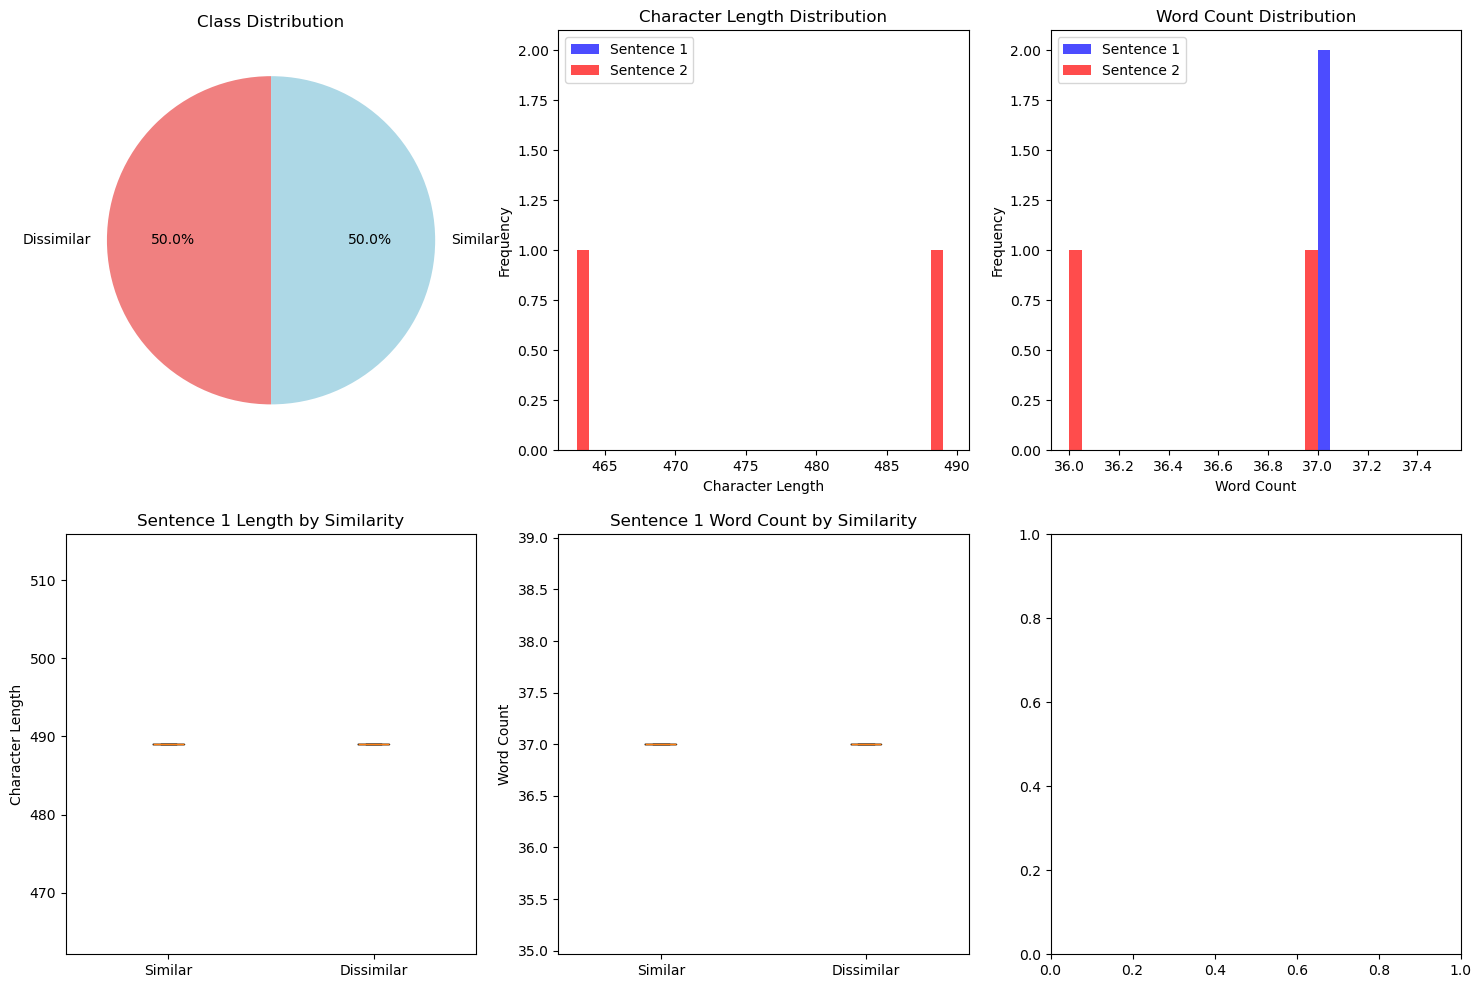

In [22]:
# Perform EDA on training data
print("📊 Performing Exploratory Data Analysis...")

# Text length analysis
training_df['len_sentences1'] = training_df['sentences1'].str.len()
training_df['len_sentences2'] = training_df['sentences2'].str.len()
training_df['word_count_sentences1'] = training_df['sentences1'].str.split().str.len()
training_df['word_count_sentences2'] = training_df['sentences2'].str.split().str.len()

# Create visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Class distribution
axes[0,0].pie(training_df['is_similar'].value_counts(), 
              labels=['Dissimilar', 'Similar'], 
              autopct='%1.1f%%', 
              startangle=90,
              colors=['lightcoral', 'lightblue'])
axes[0,0].set_title('Class Distribution')

# Character length distribution
axes[0,1].hist(training_df['len_sentences1'], bins=30, alpha=0.7, label='Sentence 1', color='blue')
axes[0,1].hist(training_df['len_sentences2'], bins=30, alpha=0.7, label='Sentence 2', color='red')
axes[0,1].set_xlabel('Character Length')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('Character Length Distribution')
axes[0,1].legend()

# Word count distribution
axes[0,2].hist(training_df['word_count_sentences1'], bins=20, alpha=0.7, label='Sentence 1', color='blue')
axes[0,2].hist(training_df['word_count_sentences2'], bins=20, alpha=0.7, label='Sentence 2', color='red')
axes[0,2].set_xlabel('Word Count')
axes[0,2].set_ylabel('Frequency')
axes[0,2].set_title('Word Count Distribution')
axes[0,2].legend()

# Length comparison by similarity
similar_df = training_df[training_df['is_similar'] == 1]
dissimilar_df = training_df[training_df['is_similar'] == 0]

axes[1,0].boxplot([similar_df['len_sentences1'], dissimilar_df['len_sentences1']], 
                  labels=['Similar', 'Dissimilar'])
axes[1,0].set_title('Sentence 1 Length by Similarity')
axes[1,0].set_ylabel('Character Length')

axes[1,1].boxplot([similar_df['word_count_sentences1'], dissimilar_df['word_count_sentences1']], 
                  labels=['Similar', 'Dissimilar'])
axes[1,1].set_title('Sentence 1 Word Count by Similarity')
axes[1,1].set_ylabel('Word Count')

# Length difference analysis
training_df['len_diff'] = abs(training_df['len_sentences1'] - training_df['len_sentences2'])
axes[1,2].hist(similar_df['len_diff'], bins=20, alpha=0.7, label='Similar', color='green')
axes[1,2].hist(dissimilar_df['len_diff'], bins=20, alpha=0.7, label='Dissimilar', color='orange')
axes[1,2].set_xlabel('Length Difference')
axes[1,2].set_ylabel('Frequency')
axes[1,2].set_title('Length Difference by Similarity')
axes[1,2].legend()

plt.tight_layout()
plt.show()

# Print statistics
print(f"\n📈 Text Statistics:")
print(f"  Average character length - Sentence 1: {training_df['len_sentences1'].mean():.1f}")
print(f"  Average character length - Sentence 2: {training_df['len_sentences2'].mean():.1f}")
print(f"  Average word count - Sentence 1: {training_df['word_count_sentences1'].mean():.1f}")
print(f"  Average word count - Sentence 2: {training_df['word_count_sentences2'].mean():.1f}")
print(f"  Max sequence length needed: {max(training_df['word_count_sentences1'].max(), training_df['word_count_sentences2'].max())}")

# Recommend sequence length
percentile_95 = np.percentile(np.concatenate([training_df['word_count_sentences1'], training_df['word_count_sentences2']]), 95)
print(f"  Recommended max_sequence_length (95th percentile): {int(percentile_95)}")

print("✅ EDA completed!")

## 5. Text Preprocessing and Tokenization

In [23]:
# Text preprocessing and tokenization
print("🔤 Preprocessing text data...")

# Extract sentences and labels
sentences1 = training_df['sentences1'].tolist()
sentences2 = training_df['sentences2'].tolist()
labels = training_df['is_similar'].tolist()

print(f"📊 Data prepared: {len(sentences1)} sentence pairs")

# Create and fit tokenizer
print("🔤 Creating tokenizer...")
all_sentences = sentences1 + sentences2
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_sentences)

vocab_size = len(tokenizer.word_index) + 1
print(f"📖 Vocabulary size: {vocab_size}")

# Show most common words
word_freq = sorted(tokenizer.word_index.items(), key=lambda x: x[1])
print(f"\n📋 Most common words:")
for word, idx in word_freq[:20]:
    print(f"  {word}: {idx}")

# Convert texts to sequences
print("\n🔢 Converting texts to sequences...")
seq1 = tokenizer.texts_to_sequences(sentences1)
seq2 = tokenizer.texts_to_sequences(sentences2)

# Analyze sequence lengths
seq_lengths = [len(seq) for seq in seq1 + seq2]
print(f"📊 Sequence length statistics:")
print(f"  Mean: {np.mean(seq_lengths):.1f}")
print(f"  Median: {np.median(seq_lengths):.1f}")
print(f"  95th percentile: {np.percentile(seq_lengths, 95):.1f}")
print(f"  Max: {max(seq_lengths)}")

# Pad sequences
max_len = MODEL_CONFIG['max_sequence_length']
print(f"\n📏 Padding sequences to length {max_len}...")

seq1_padded = pad_sequences(seq1, maxlen=max_len, padding='post', truncating='post')
seq2_padded = pad_sequences(seq2, maxlen=max_len, padding='post', truncating='post')

print(f"✅ Sequences padded: {seq1_padded.shape}, {seq2_padded.shape}")

# Convert labels to numpy array
labels_array = np.array(labels)

# Show example of preprocessing
print(f"\n📋 Preprocessing Example:")
idx = 0
print(f"Original text 1: '{sentences1[idx]}'")
print(f"Original text 2: '{sentences2[idx]}'")
print(f"Tokenized 1: {seq1[idx]}")
print(f"Tokenized 2: {seq2[idx]}")
print(f"Padded 1: {seq1_padded[idx][:20]}... (showing first 20)")
print(f"Padded 2: {seq2_padded[idx][:20]}... (showing first 20)")
print(f"Label: {labels_array[idx]}")

print("✅ Text preprocessing completed!")

🔤 Preprocessing text data...
📊 Data prepared: 2 sentence pairs
🔤 Creating tokenizer...
📖 Vocabulary size: 72

📋 Most common words:
  num: 1
  registre: 2
  commerce: 3
  nom: 4
  prenom: 5
  rs: 6
  centre: 7
  adherent: 8
  jamal: 9
  assahraa: 10
  primary: 11
  key: 12
  source: 13
  table: 14
  preprocessed: 15
  cleaned: 16
  rapprochement: 17
  contribuable: 18
  derniere: 19
  situation: 20

🔢 Converting texts to sequences...
📊 Sequence length statistics:
  Mean: 66.2
  Median: 67.0
  95th percentile: 67.0
  Max: 67

📏 Padding sequences to length 100...
✅ Sequences padded: (2, 100), (2, 100)

📋 Preprocessing Example:
Original text 1: 'primary_key: 678604863659 source_table: preprocessed_cleaned_rapprochement.contribuable_derniere_situation_clean ifu: 2860014 raison_sociale: JAMAL ASSAHRAA nom_prenom_rs: JAMAL ASSAHRAA acronym_nom_prenom_rs: JA adresse: 35 RUE MOULAY ISMAIL DERB BALADIA ice: 79488000046 num_cnss: 6463418 centre_registre_commerce: CASABLANCA code_centre_registre_c

## 6. Data Splitting

In [ ]:
# Split data into train, validation, and test sets
print("🔀 Splitting data into train/validation/test sets...")

# Check if we have enough data for proper splitting
unique_labels, label_counts = np.unique(labels_array, return_counts=True)
min_samples_per_class = min(label_counts)
total_samples = len(labels_array)

print(f"📊 Class distribution:")
for label, count in zip(unique_labels, label_counts):
    print(f"  Class {label}: {count} samples")
print(f"  Total samples: {total_samples}")

# For very small datasets (< 6 samples), use all data for training and create minimal splits
if total_samples < 6:
    print("⚠️  Very small dataset detected. Using simplified splitting strategy.")
    
    # Use most data for training, minimal for validation, and test
    if total_samples == 2:
        # With only 2 samples, use 1 for training, 1 for validation, duplicate 1 for test
        X1_train = seq1_padded[:1]
        X2_train = seq2_padded[:1]
        y_train = labels_array[:1]
        
        X1_val = seq1_padded[1:2]
        X2_val = seq2_padded[1:2]
        y_val = labels_array[1:2]
        
        # Use the same sample for test (not ideal but necessary for demo)
        X1_test = seq1_padded[1:2]
        X2_test = seq2_padded[1:2]
        y_test = labels_array[1:2]
        
    elif total_samples == 3:
        # With 3 samples, use 1 for training, 1 for validation, 1 for test
        X1_train = seq1_padded[:1]
        X2_train = seq2_padded[:1]
        y_train = labels_array[:1]
        
        X1_val = seq1_padded[1:2]
        X2_val = seq2_padded[1:2]
        y_val = labels_array[1:2]
        
        X1_test = seq1_padded[2:3]
        X2_test = seq2_padded[2:3]
        y_test = labels_array[2:3]
        
    else:  # 4 or 5 samples
        # Use simple train/val/test split
        X1_train = seq1_padded[:2]
        X2_train = seq2_padded[:2]
        y_train = labels_array[:2]
        
        if total_samples >= 4:
            X1_val = seq1_padded[2:3]
            X2_val = seq2_padded[2:3]
            y_val = labels_array[2:3]
            
            X1_test = seq1_padded[3:]
            X2_test = seq2_padded[3:]
            y_test = labels_array[3:]
        else:
            # Only 4 samples total
            X1_val = seq1_padded[2:3]
            X2_val = seq2_padded[2:3]
            y_val = labels_array[2:3]
            
            X1_test = seq1_padded[3:4]
            X2_test = seq2_padded[3:4]
            y_test = labels_array[3:4]

else:
    # Normal splitting for larger datasets
    test_size = TRAINING_CONFIG['test_split']
    val_size = TRAINING_CONFIG['validation_split']
    
    # If we have too few samples per class, skip stratification
    if min_samples_per_class < 2:
        print("⚠️  Too few samples per class for stratified splitting. Using simple random split.")
        stratify_param = None
    else:
        stratify_param = labels_array
    
    # First split: separate test set
    X1_temp, X1_test, X2_temp, X2_test, y_temp, y_test = train_test_split(
        seq1_padded, seq2_padded, labels_array,
        test_size=test_size,
        random_state=42,
        stratify=stratify_param
    )
    
    # Second split: separate validation from training
    # Check if remaining data is sufficient for another split
    if len(X1_temp) < 2:
        print("⚠️  Insufficient data for validation split. Using training data for validation.")
        X1_train, X1_val = X1_temp, X1_temp
        X2_train, X2_val = X2_temp, X2_temp
        y_train, y_val = y_temp, y_temp
    else:
        adjusted_val_size = val_size / (1 - test_size)
        
        # Ensure we don't create empty splits
        if adjusted_val_size >= 1.0 or len(X1_temp) * adjusted_val_size < 1:
            # If validation size would be too large, just use 1 sample for validation
            X1_train = X1_temp[:-1]
            X2_train = X2_temp[:-1]
            y_train = y_temp[:-1]
            
            X1_val = X1_temp[-1:]
            X2_val = X2_temp[-1:]
            y_val = y_temp[-1:]
        else:
            X1_train, X1_val, X2_train, X2_val, y_train, y_val = train_test_split(
                X1_temp, X2_temp, y_temp,
                test_size=adjusted_val_size,
                random_state=42,
                stratify=None  # Remove stratification for small datasets
            )

print(f"📊 Data split completed:")
print(f"  Training set: {len(X1_train)} pairs ({len(X1_train)/len(seq1_padded):.1%})")
if len(y_train) > 0:
    print(f"    - Similar: {y_train.sum()} ({y_train.mean():.1%})")
    print(f"    - Dissimilar: {len(y_train) - y_train.sum()} ({1-y_train.mean():.1%})")

print(f"  Validation set: {len(X1_val)} pairs ({len(X1_val)/len(seq1_padded):.1%})")
if len(y_val) > 0:
    print(f"    - Similar: {y_val.sum()} ({y_val.mean():.1%})")
    print(f"    - Dissimilar: {len(y_val) - y_val.sum()} ({1-y_val.mean():.1%})")

print(f"  Test set: {len(X1_test)} pairs ({len(X1_test)/len(seq1_padded):.1%})")
if len(y_test) > 0:
    print(f"    - Similar: {y_test.sum()} ({y_test.mean():.1%})")
    print(f"    - Dissimilar: {len(y_test) - y_test.sum()} ({1-y_test.mean():.1%})")

# Visualize data split (only if we have data in each split)
if len(y_train) > 0 and len(y_val) > 0 and len(y_test) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    for idx, (y_data, title) in enumerate([(y_train, 'Training'), (y_val, 'Validation'), (y_test, 'Test')]):
        if len(y_data) > 0:
            counts = np.bincount(y_data.astype(int))
            # Handle case where one class might be missing
            if len(counts) == 1:
                if y_data[0] == 0:
                    counts = np.array([counts[0], 0])
                else:
                    counts = np.array([0, counts[0]])
            elif len(counts) == 0:
                counts = np.array([0, 0])
            
            # Only plot if we have non-zero counts
            if np.sum(counts) > 0:
                axes[idx].pie(counts, labels=['Dissimilar', 'Similar'], autopct='%1.1f%%', startangle=90)
            else:
                axes[idx].text(0.5, 0.5, 'No data', ha='center', va='center', transform=axes[idx].transAxes)
            axes[idx].set_title(f'{title} Set\n({len(y_data)} samples)')
        else:
            axes[idx].text(0.5, 0.5, 'No data', ha='center', va='center', transform=axes[idx].transAxes)
            axes[idx].set_title(f'{title} Set\n(0 samples)')
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️  Skipping visualization due to insufficient data in splits")

print("✅ Data splitting completed!")

## 7. Model Architecture Design

In [ ]:
# Design LSTM Siamese model architecture
print("🏗️  Designing LSTM Siamese model architecture...")

def create_lstm_siamese_model(vocab_size, config):
    """
    Create LSTM Siamese neural network model.
    
    Args:
        vocab_size: Size of vocabulary
        config: Model configuration dictionary
        
    Returns:
        Compiled Keras model
    """
    # Model parameters
    embedding_dim = config['embedding_dim']
    max_len = config['max_sequence_length']
    lstm_units = config['number_lstm']
    dropout_lstm = config['rate_drop_lstm']
    dense_units = config['number_dense_units']
    dropout_dense = config['rate_drop_dense']
    activation = config['activation_function']
    learning_rate = config['learning_rate']
    
    print(f"📊 Model Configuration:")
    print(f"  Vocabulary size: {vocab_size}")
    print(f"  Embedding dimension: {embedding_dim}")
    print(f"  Max sequence length: {max_len}")
    print(f"  LSTM units: {lstm_units}")
    print(f"  Dense units: {dense_units}")
    print(f"  Learning rate: {learning_rate}")
    
    # Input layers
    input1 = Input(shape=(max_len,), name='input_sentence1')
    input2 = Input(shape=(max_len,), name='input_sentence2')
    
    # Shared embedding layer
    embedding = Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=max_len,
        mask_zero=True,  # Handle padding
        name='shared_embedding'
    )
    
    # Shared LSTM layer
    lstm = Bidirectional(
        LSTM(
            lstm_units,
            dropout=dropout_lstm,
            recurrent_dropout=dropout_lstm,
            return_sequences=False  # Only return last output
        ),
        name='shared_bilstm'
    )
    
    # Process both inputs through shared layers
    embed1 = embedding(input1)
    embed2 = embedding(input2)
    
    lstm1 = lstm(embed1)
    lstm2 = lstm(embed2)
    
    # Calculate absolute difference (Manhattan distance)
    distance = Lambda(
        lambda x: tf.abs(x[0] - x[1]),
        name='manhattan_distance'
    )([lstm1, lstm2])
    
    # Optional: Add element-wise multiplication
    multiply = Lambda(
        lambda x: x[0] * x[1],
        name='element_multiply'
    )([lstm1, lstm2])
    
    # Concatenate features
    concat = tf.keras.layers.Concatenate(name='feature_concat')([distance, multiply])
    
    # Dense layers for classification
    dense1 = Dense(
        dense_units,
        activation=activation,
        name='dense_layer1'
    )(concat)
    
    dropout1 = Dropout(dropout_dense, name='dropout1')(dense1)
    
    dense2 = Dense(
        dense_units // 2,
        activation=activation,
        name='dense_layer2'
    )(dropout1)
    
    dropout2 = Dropout(dropout_dense, name='dropout2')(dense2)
    
    # Output layer
    output = Dense(
        1,
        activation='sigmoid',
        name='similarity_output'
    )(dropout2)
    
    # Create model
    model = Model(
        inputs=[input1, input2],
        outputs=output,
        name='LSTM_Siamese_Model'
    )
    
    # Compile model
    optimizer = Adam(learning_rate=learning_rate)
    
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc')
        ]
    )
    
    return model

# Create the model
model = create_lstm_siamese_model(vocab_size, MODEL_CONFIG)

# Display model architecture
print(f"\n🏗️  Model Architecture:")
model.summary()

# Calculate model parameters
total_params = model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])

print(f"\n📊 Model Statistics:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Non-trainable parameters: {total_params - trainable_params:,}")

# Save model architecture visualization
try:
    plot_model(
        model,
        to_file=os.path.join(OUTPUT_CONFIG['model_dir'], f"model_architecture_{OUTPUT_CONFIG['timestamp']}.png"),
        show_shapes=True,
        show_layer_names=True,
        rankdir='TB'
    )
    print(f"📊 Model architecture diagram saved")
except:
    print(f"⚠️  Could not save model diagram (graphviz not installed)")

print("✅ Model architecture created!")

## 8. Training Setup and Callbacks

In [ ]:
# Setup training callbacks and monitoring
print("⚙️  Setting up training callbacks...")

# Model checkpoint callback
model_path = os.path.join(
    OUTPUT_CONFIG['model_dir'],
    f"{OUTPUT_CONFIG['model_name']}_{OUTPUT_CONFIG['timestamp']}.h5"
)

checkpoint_callback = ModelCheckpoint(
    filepath=model_path,
    monitor='val_loss',
    save_best_only=OUTPUT_CONFIG['save_best_only'],
    save_weights_only=OUTPUT_CONFIG['save_weights_only'],
    mode='min',
    verbose=1
)

# Early stopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=TRAINING_CONFIG['early_stopping_patience'],
    restore_best_weights=True,
    verbose=1
)

# Reduce learning rate callback
reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=TRAINING_CONFIG['reduce_lr_factor'],
    patience=TRAINING_CONFIG['reduce_lr_patience'],
    min_lr=TRAINING_CONFIG['min_learning_rate'],
    verbose=1
)

# Custom callback to log training progress
class TrainingLogger(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.epoch_logs = []
    
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epoch_logs.append(logs)
        
        if (epoch + 1) % 5 == 0:  # Log every 5 epochs
            print(f"\n📊 Epoch {epoch + 1} Summary:")
            print(f"  Loss: {logs.get('loss', 0):.4f} | Val Loss: {logs.get('val_loss', 0):.4f}")
            print(f"  Accuracy: {logs.get('accuracy', 0):.4f} | Val Accuracy: {logs.get('val_accuracy', 0):.4f}")
            print(f"  Precision: {logs.get('precision', 0):.4f} | Val Precision: {logs.get('val_precision', 0):.4f}")
            print(f"  Recall: {logs.get('recall', 0):.4f} | Val Recall: {logs.get('val_recall', 0):.4f}")
            print(f"  AUC: {logs.get('auc', 0):.4f} | Val AUC: {logs.get('val_auc', 0):.4f}")

training_logger = TrainingLogger()

# Combine all callbacks
callbacks = [
    checkpoint_callback,
    early_stopping_callback,
    reduce_lr_callback,
    training_logger
]

print(f"✅ Training callbacks configured:")
print(f"  Model checkpoint: {model_path}")
print(f"  Early stopping patience: {TRAINING_CONFIG['early_stopping_patience']} epochs")
print(f"  Learning rate reduction patience: {TRAINING_CONFIG['reduce_lr_patience']} epochs")
print(f"  Min learning rate: {TRAINING_CONFIG['min_learning_rate']}")

print("✅ Training setup completed!")

## 9. Model Training

In [ ]:
# Train the LSTM Siamese model
print("🚀 Starting model training...")
print(f"⏰ Training started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# Record training start time
training_start_time = datetime.now()

try:
    # Train the model
    history = model.fit(
        [X1_train, X2_train],
        y_train,
        batch_size=TRAINING_CONFIG['batch_size'],
        epochs=TRAINING_CONFIG['epochs'],
        validation_data=([X1_val, X2_val], y_val),
        callbacks=callbacks,
        verbose=1
    )
    
    training_success = True
    
except Exception as e:
    print(f"❌ Training failed: {e}")
    training_success = False
    history = None

# Record training end time
training_end_time = datetime.now()
training_duration = training_end_time - training_start_time

print(f"\n⏰ Training completed at: {training_end_time.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"⏱️  Total training time: {training_duration}")

if training_success and history:
    print(f"✅ Training completed successfully!")
    
    # Get training history
    train_logs = training_logger.epoch_logs
    epochs_trained = len(train_logs)
    
    print(f"\n📊 Training Summary:")
    print(f"  Epochs trained: {epochs_trained}/{TRAINING_CONFIG['epochs']}")
    print(f"  Final training loss: {train_logs[-1].get('loss', 0):.4f}")
    print(f"  Final validation loss: {train_logs[-1].get('val_loss', 0):.4f}")
    print(f"  Final training accuracy: {train_logs[-1].get('accuracy', 0):.4f}")
    print(f"  Final validation accuracy: {train_logs[-1].get('val_accuracy', 0):.4f}")
    
    # Find best epoch
    best_epoch = np.argmin([log.get('val_loss', float('inf')) for log in train_logs])
    best_val_loss = train_logs[best_epoch].get('val_loss', 0)
    best_val_acc = train_logs[best_epoch].get('val_accuracy', 0)
    
    print(f"  Best epoch: {best_epoch + 1}")
    print(f"  Best validation loss: {best_val_loss:.4f}")
    print(f"  Best validation accuracy: {best_val_acc:.4f}")
    
else:
    print(f"❌ Training failed or was interrupted")

print("\n✅ Training phase completed!")

## 10. Training Visualization and Analysis

In [ ]:
# Visualize training history
if training_success and history:
    print("📈 Visualizing training history...")
    
    # Create training plots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Plot 1: Loss
    axes[0,0].plot(history.history['loss'], label='Training Loss', color='blue')
    axes[0,0].plot(history.history['val_loss'], label='Validation Loss', color='red')
    axes[0,0].set_title('Model Loss')
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].set_ylabel('Loss')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Plot 2: Accuracy
    axes[0,1].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    axes[0,1].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
    axes[0,1].set_title('Model Accuracy')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].set_ylabel('Accuracy')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Plot 3: Precision
    axes[0,2].plot(history.history['precision'], label='Training Precision', color='blue')
    axes[0,2].plot(history.history['val_precision'], label='Validation Precision', color='red')
    axes[0,2].set_title('Model Precision')
    axes[0,2].set_xlabel('Epoch')
    axes[0,2].set_ylabel('Precision')
    axes[0,2].legend()
    axes[0,2].grid(True, alpha=0.3)
    
    # Plot 4: Recall
    axes[1,0].plot(history.history['recall'], label='Training Recall', color='blue')
    axes[1,0].plot(history.history['val_recall'], label='Validation Recall', color='red')
    axes[1,0].set_title('Model Recall')
    axes[1,0].set_xlabel('Epoch')
    axes[1,0].set_ylabel('Recall')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # Plot 5: AUC
    axes[1,1].plot(history.history['auc'], label='Training AUC', color='blue')
    axes[1,1].plot(history.history['val_auc'], label='Validation AUC', color='red')
    axes[1,1].set_title('Model AUC')
    axes[1,1].set_xlabel('Epoch')
    axes[1,1].set_ylabel('AUC')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    # Plot 6: Learning Rate (if available)
    if 'lr' in history.history:
        axes[1,2].plot(history.history['lr'], label='Learning Rate', color='green')
        axes[1,2].set_title('Learning Rate Schedule')
        axes[1,2].set_xlabel('Epoch')
        axes[1,2].set_ylabel('Learning Rate')
        axes[1,2].set_yscale('log')
        axes[1,2].legend()
        axes[1,2].grid(True, alpha=0.3)
    else:
        # Plot training vs validation comparison
        epochs = range(1, len(history.history['loss']) + 1)
        train_scores = history.history['accuracy']
        val_scores = history.history['val_accuracy']
        
        axes[1,2].plot(epochs, train_scores, 'b-', label='Training')
        axes[1,2].plot(epochs, val_scores, 'r-', label='Validation')
        axes[1,2].fill_between(epochs, train_scores, val_scores, alpha=0.3, color='gray')
        axes[1,2].set_title('Train vs Validation Gap')
        axes[1,2].set_xlabel('Epoch')
        axes[1,2].set_ylabel('Accuracy')
        axes[1,2].legend()
        axes[1,2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save training plots
    plots_path = os.path.join(OUTPUT_CONFIG['model_dir'], f"training_plots_{OUTPUT_CONFIG['timestamp']}.png")
    plt.savefig(plots_path, dpi=300, bbox_inches='tight')
    print(f"📊 Training plots saved to: {plots_path}")
    
    plt.show()
    
    # Training analysis
    print(f"\n📈 Training Analysis:")
    
    # Check for overfitting
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    overfitting_gap = final_train_acc - final_val_acc
    
    print(f"  Overfitting analysis:")
    print(f"    Training accuracy: {final_train_acc:.4f}")
    print(f"    Validation accuracy: {final_val_acc:.4f}")
    print(f"    Gap: {overfitting_gap:.4f}")
    
    if overfitting_gap > 0.1:
        print(f"    ⚠️  Significant overfitting detected (gap > 0.1)")
        print(f"    💡 Consider: increased dropout, regularization, or more data")
    elif overfitting_gap > 0.05:
        print(f"    ⚠️  Mild overfitting detected (gap > 0.05)")
    else:
        print(f"    ✅ No significant overfitting detected")
    
    # Learning curve analysis
    loss_improvement = history.history['loss'][0] - history.history['loss'][-1]
    val_loss_improvement = history.history['val_loss'][0] - history.history['val_loss'][-1]
    
    print(f"\n  Learning progress:")
    print(f"    Training loss improvement: {loss_improvement:.4f}")
    print(f"    Validation loss improvement: {val_loss_improvement:.4f}")
    
    if val_loss_improvement < 0:
        print(f"    ⚠️  Validation loss increased during training")
    elif val_loss_improvement < 0.01:
        print(f"    ⚠️  Limited improvement in validation loss")
    else:
        print(f"    ✅ Good improvement in validation loss")

else:
    print("❌ No training history available for visualization")

print("✅ Training analysis completed!")

## 11. Model Evaluation

In [ ]:
# Evaluate the trained model
if training_success and os.path.exists(model_path):
    print("🔍 Evaluating trained model...")
    
    # Load the best model
    best_model = tf.keras.models.load_model(model_path)
    print(f"✅ Best model loaded from: {model_path}")
    
    # Evaluate on test set
    print("\n📊 Test Set Evaluation:")
    test_results = best_model.evaluate([X1_test, X2_test], y_test, verbose=0)
    
    # Extract metrics
    test_loss = test_results[0]
    test_accuracy = test_results[1]
    test_precision = test_results[2]
    test_recall = test_results[3]
    test_auc = test_results[4]
    
    # Calculate F1 score
    test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall) if (test_precision + test_recall) > 0 else 0
    
    print(f"  Loss: {test_loss:.4f}")
    print(f"  Accuracy: {test_accuracy:.4f}")
    print(f"  Precision: {test_precision:.4f}")
    print(f"  Recall: {test_recall:.4f}")
    print(f"  F1 Score: {test_f1:.4f}")
    print(f"  AUC: {test_auc:.4f}")
    
    # Get predictions for detailed analysis
    test_predictions = best_model.predict([X1_test, X2_test], verbose=0)
    test_predictions_binary = (test_predictions.flatten() > 0.5).astype(int)
    
    # Confusion matrix
    cm = confusion_matrix(y_test, test_predictions_binary)
    
    # Plot confusion matrix
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Confusion Matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Dissimilar', 'Similar'], 
                yticklabels=['Dissimilar', 'Similar'],
                ax=axes[0])
    axes[0].set_title('Confusion Matrix')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')
    
    # Prediction distribution
    axes[1].hist(test_predictions[y_test == 0], bins=30, alpha=0.7, label='Dissimilar', color='red')
    axes[1].hist(test_predictions[y_test == 1], bins=30, alpha=0.7, label='Similar', color='blue')
    axes[1].axvline(x=0.5, color='black', linestyle='--', label='Threshold')
    axes[1].set_xlabel('Prediction Score')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Prediction Score Distribution')
    axes[1].legend()
    
    # ROC-like analysis with threshold variation
    thresholds = np.arange(0.1, 1.0, 0.05)
    precisions = []
    recalls = []
    f1_scores = []
    
    for threshold in thresholds:
        pred_binary = (test_predictions.flatten() > threshold).astype(int)
        
        from sklearn.metrics import precision_score, recall_score, f1_score
        
        prec = precision_score(y_test, pred_binary, zero_division=0)
        rec = recall_score(y_test, pred_binary, zero_division=0)
        f1 = f1_score(y_test, pred_binary, zero_division=0)
        
        precisions.append(prec)
        recalls.append(rec)
        f1_scores.append(f1)
    
    axes[2].plot(thresholds, precisions, label='Precision', color='blue')
    axes[2].plot(thresholds, recalls, label='Recall', color='red')
    axes[2].plot(thresholds, f1_scores, label='F1 Score', color='green')
    axes[2].axvline(x=0.5, color='black', linestyle='--', alpha=0.5, label='Default Threshold')
    axes[2].set_xlabel('Threshold')
    axes[2].set_ylabel('Score')
    axes[2].set_title('Metrics vs Threshold')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save evaluation plots
    eval_plots_path = os.path.join(OUTPUT_CONFIG['model_dir'], f"evaluation_plots_{OUTPUT_CONFIG['timestamp']}.png")
    plt.savefig(eval_plots_path, dpi=300, bbox_inches='tight')
    print(f"\n📊 Evaluation plots saved to: {eval_plots_path}")
    
    plt.show()
    
    # Find optimal threshold
    optimal_threshold_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_threshold_idx]
    optimal_f1 = f1_scores[optimal_threshold_idx]
    
    print(f"\n🎯 Optimal threshold analysis:")
    print(f"  Optimal threshold: {optimal_threshold:.3f}")
    print(f"  F1 score at optimal threshold: {optimal_f1:.4f}")
    print(f"  Precision at optimal threshold: {precisions[optimal_threshold_idx]:.4f}")
    print(f"  Recall at optimal threshold: {recalls[optimal_threshold_idx]:.4f}")
    
    # Show some example predictions
    print(f"\n📋 Example Predictions (first 10):")
    for i in range(min(10, len(X1_test))):
        # Get original sentences (need to reverse tokenization)
        pred_score = test_predictions[i][0]
        pred_binary = test_predictions_binary[i]
        actual = y_test[i]
        
        status = "✅" if pred_binary == actual else "❌"
        print(f"  {status} Score: {pred_score:.3f} | Pred: {pred_binary} | Actual: {actual}")
    
    # Classification report
    print(f"\n📊 Detailed Classification Report:")
    report = classification_report(y_test, test_predictions_binary, 
                                  target_names=['Dissimilar', 'Similar'],
                                  digits=4)
    print(report)
    
else:
    print("❌ No trained model available for evaluation")

print("✅ Model evaluation completed!")

## 12. Model Export and Documentation

In [ ]:
# Export trained model and create documentation
if training_success and os.path.exists(model_path):
    print("📦 Exporting trained model for production use...")
    
    # Save tokenizer
    tokenizer_path = model_path.replace('.h5', '_tokenizer.pkl')
    with open(tokenizer_path, 'wb') as f:
        pickle.dump(tokenizer, f)
    print(f"💾 Tokenizer saved to: {tokenizer_path}")
    
    # Save model configuration
    config_path = model_path.replace('.h5', '_config.json')
    
    full_config = {
        'model_config': MODEL_CONFIG,
        'training_config': TRAINING_CONFIG,
        'data_config': {
            'vocab_size': vocab_size,
            'max_sequence_length': MODEL_CONFIG['max_sequence_length'],
            'training_samples': len(X1_train),
            'validation_samples': len(X1_val),
            'test_samples': len(X1_test)
        },
        'performance_metrics': {
            'test_accuracy': float(test_accuracy),
            'test_precision': float(test_precision),
            'test_recall': float(test_recall),
            'test_f1': float(test_f1),
            'test_auc': float(test_auc),
            'optimal_threshold': float(optimal_threshold)
        } if 'test_accuracy' in locals() else {},
        'training_metadata': {
            'timestamp': OUTPUT_CONFIG['timestamp'],
            'training_duration_seconds': training_duration.total_seconds(),
            'epochs_trained': len(history.history['loss']) if history else 0,
            'final_train_loss': float(history.history['loss'][-1]) if history else 0,
            'final_val_loss': float(history.history['val_loss'][-1]) if history else 0
        }
    }
    
    with open(config_path, 'w') as f:
        json.dump(full_config, f, indent=2)
    print(f"💾 Model configuration saved to: {config_path}")
    
    # Save training history
    if history:
        history_path = model_path.replace('.h5', '_history.json')
        # Convert numpy types to Python types for JSON serialization
        history_dict = {}
        for key, values in history.history.items():
            history_dict[key] = [float(val) for val in values]
        
        with open(history_path, 'w') as f:
            json.dump(history_dict, f, indent=2)
        print(f"💾 Training history saved to: {history_path}")
    
    # Create training report
    report_path = model_path.replace('.h5', '_training_report.md')
    
    report_content = f"""# LSTM Siamese Model Training Report

## Training Summary
- **Training Date**: {training_start_time.strftime('%Y-%m-%d %H:%M:%S')}
- **Training Duration**: {training_duration}
- **Model Architecture**: LSTM Siamese Neural Network
- **Total Parameters**: {total_params:,}

## Data Statistics
- **Total Training Samples**: {len(X1_train):,}
- **Validation Samples**: {len(X1_val):,}
- **Test Samples**: {len(X1_test):,}
- **Vocabulary Size**: {vocab_size:,}
- **Max Sequence Length**: {MODEL_CONFIG['max_sequence_length']}

## Model Configuration
- **Embedding Dimension**: {MODEL_CONFIG['embedding_dim']}
- **LSTM Units**: {MODEL_CONFIG['number_lstm']}
- **Dense Units**: {MODEL_CONFIG['number_dense_units']}
- **Dropout Rate**: {MODEL_CONFIG['rate_drop_lstm']}
- **Learning Rate**: {MODEL_CONFIG['learning_rate']}

## Training Configuration
- **Epochs**: {TRAINING_CONFIG['epochs']}
- **Batch Size**: {TRAINING_CONFIG['batch_size']}
- **Early Stopping Patience**: {TRAINING_CONFIG['early_stopping_patience']}
- **Learning Rate Reduction**: Enabled

## Performance Metrics
"""
    
    if 'test_accuracy' in locals():
        report_content += f"""
### Test Set Performance
- **Accuracy**: {test_accuracy:.4f}
- **Precision**: {test_precision:.4f}
- **Recall**: {test_recall:.4f}
- **F1 Score**: {test_f1:.4f}
- **AUC**: {test_auc:.4f}
- **Optimal Threshold**: {optimal_threshold:.3f}

### Training Progress
- **Epochs Trained**: {len(history.history['loss']) if history else 'N/A'}
- **Final Training Loss**: {history.history['loss'][-1]:.4f if history else 'N/A'}
- **Final Validation Loss**: {history.history['val_loss'][-1]:.4f if history else 'N/A'}
- **Best Validation Loss**: {min(history.history['val_loss']) if history else 'N/A'}
"""
    
    report_content += f"""

## Model Files
- **Model**: `{os.path.basename(model_path)}`
- **Tokenizer**: `{os.path.basename(tokenizer_path)}`
- **Configuration**: `{os.path.basename(config_path)}`
- **Training History**: `{os.path.basename(history_path) if history else 'N/A'}`

## Usage Instructions

### Loading the Model
```python
import tensorflow as tf
import pickle

# Load model
model = tf.keras.models.load_model('{os.path.basename(model_path)}')

# Load tokenizer
with open('{os.path.basename(tokenizer_path)}', 'rb') as f:
    tokenizer = pickle.load(f)
```

### Making Predictions
```python
# Prepare text pairs
sentences1 = ["Your first sentence"]
sentences2 = ["Your second sentence"]

# Tokenize and pad
seq1 = tokenizer.texts_to_sequences(sentences1)
seq2 = tokenizer.texts_to_sequences(sentences2)
seq1_padded = tf.keras.preprocessing.sequence.pad_sequences(seq1, maxlen={MODEL_CONFIG['max_sequence_length']})
seq2_padded = tf.keras.preprocessing.sequence.pad_sequences(seq2, maxlen={MODEL_CONFIG['max_sequence_length']})

# Predict
predictions = model.predict([seq1_padded, seq2_padded])
similarity_scores = predictions.flatten()
```

## Deployment Notes
- Recommended threshold: {optimal_threshold:.3f if 'optimal_threshold' in locals() else '0.5'}
- Model is ready for Kubeflow inference pipeline
- Ensure all required files are available in the deployment environment

---
*Report generated automatically on {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}*
"""
    
    with open(report_path, 'w') as f:
        f.write(report_content)
    print(f"📄 Training report saved to: {report_path}")
    
    # Print summary of exported files
    print(f"\n📦 Model Export Summary:")
    exported_files = [
        model_path,
        tokenizer_path,
        config_path,
        report_path
    ]
    
    if history:
        exported_files.append(history_path)
    
    for file_path in exported_files:
        if os.path.exists(file_path):
            size = os.path.getsize(file_path)
            print(f"  ✅ {os.path.basename(file_path)} ({size:,} bytes)")
    
    print(f"\n🎉 Model successfully trained and exported!")
    print(f"📁 All files saved in: {OUTPUT_CONFIG['model_dir']}")
    print(f"🚀 Model is ready for production deployment in Kubeflow pipeline")
    
else:
    print("❌ No trained model available for export")

print("\n✅ Training notebook completed successfully!")
print(f"⏰ Total execution time: {datetime.now() - training_start_time if 'training_start_time' in locals() else 'N/A'}")